Loading image path now
Image shape: (2048, 2048)


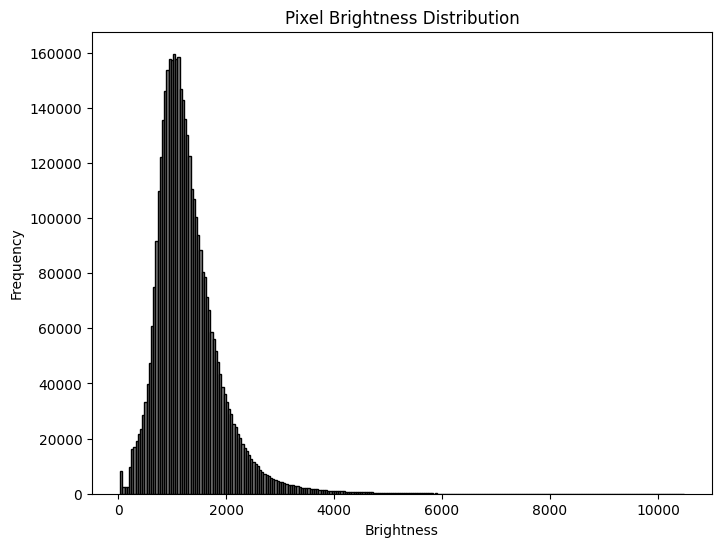

In [1]:
# Cell 1: Setup, Loading, and Triage

# Import necessary libraries
import os
import cv2
import json
import tifffile
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Specify the path to the TIFF file
print("Loading image path now")
img_path = '/Users/ariasarch/Desktop/PNN 1000 long.tif'

# Load the TIFF file
img = tifffile.imread(img_path)

# Print the shape of the image to understand its dimensions
print("Image shape:", img.shape)

# Flatten the grayscale image to create a 1D array of pixel brightness values
pixels = img.flatten()

# Plot a histogram of the pixel brightness values
plt.figure(figsize=(8, 6))
plt.hist(pixels, bins=256, color='gray', edgecolor='black')
plt.title("Pixel Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()


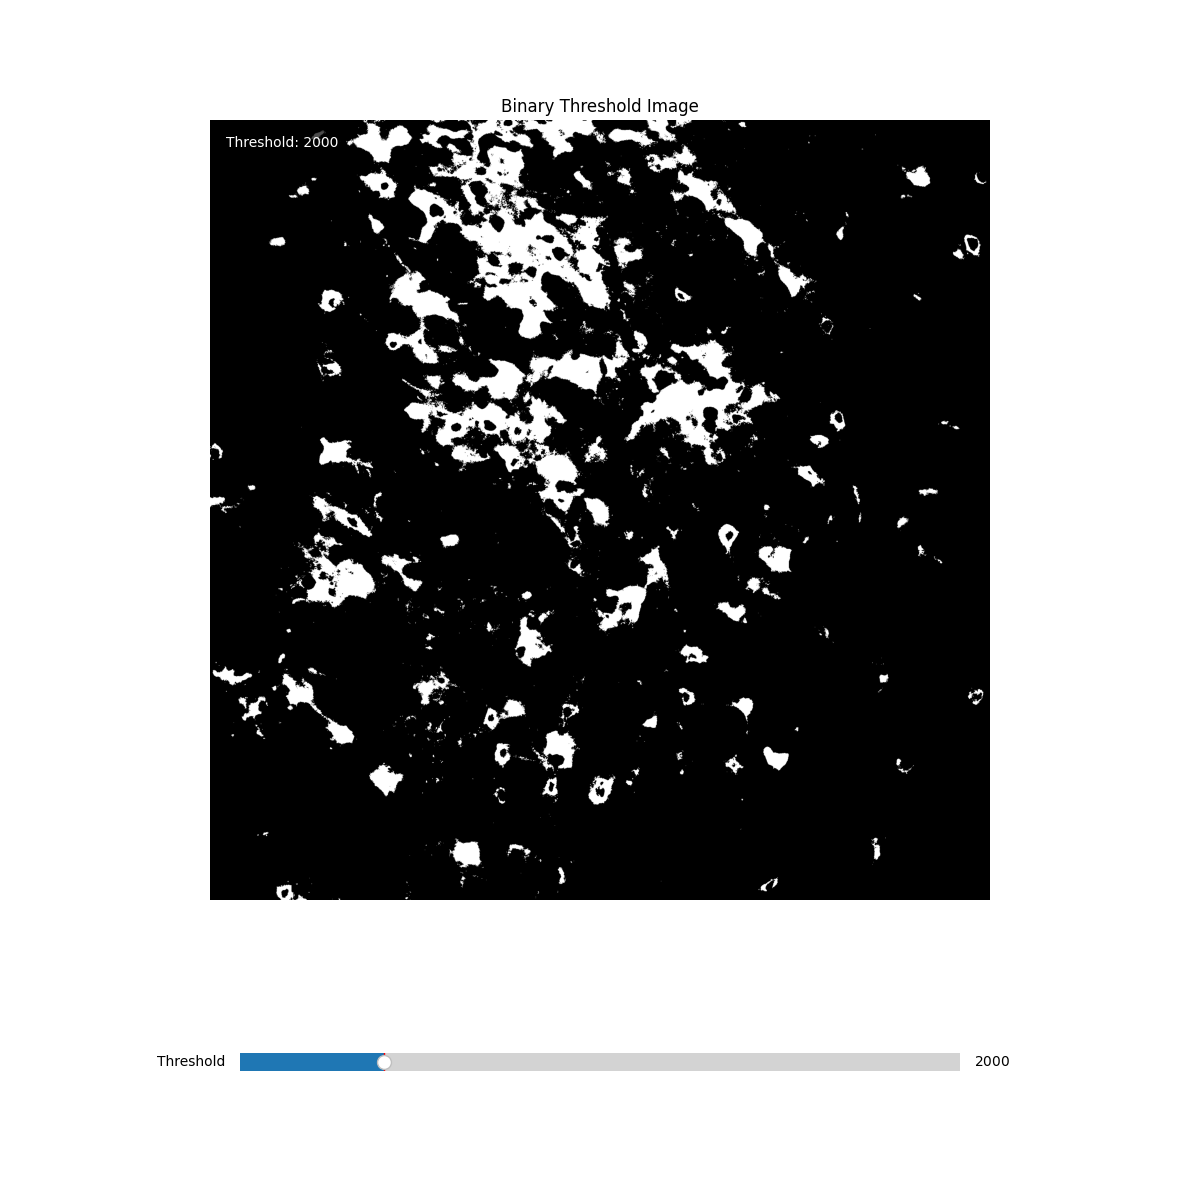

In [2]:
# Cell 2: An Interactive Plot shoving anything below a certain value to zero and anything above to 1. 

# For Interactive Plotting
%matplotlib widget

# Calculate the aspect ratio of the image
aspect_ratio = img.shape[1] / img.shape[0]

# Create a figure with size based on aspect ratio
fig = plt.figure(figsize=(12, 12/aspect_ratio))

# Create main axis with appropriate position to fill the space
main_ax = plt.axes([0.1, 0.25, 0.8, 0.65])

# Set initial brightness threshold
init_threshold = 2000

# Create binary image based on threshold
binary_img = (img > init_threshold).astype(np.uint8) * 255

# Display the initial image
im_display = main_ax.imshow(binary_img, cmap='gray')
main_ax.set_title("Binary Threshold Image")
main_ax.axis('off')

# Add text annotation for threshold value
threshold_text = main_ax.text(0.02, 0.98, f'Threshold: {init_threshold}', 
                         transform=main_ax.transAxes,
                         color='white',
                         bbox=dict(facecolor='black', alpha=0.7),
                         verticalalignment='top')

# Create an axis for the slider with range matching the data
max_histogram_value = 10000 # From the above histogram 
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
threshold_slider = Slider(slider_ax, 'Threshold', 0, max_histogram_value, valinit=init_threshold)

# Function for the slider 
def update(val):
    threshold = int(threshold_slider.val)
    binary_img = (img > threshold).astype(np.uint8) * 255
    im_display.set_data(binary_img)
    threshold_text.set_text(f'Threshold: {threshold}')
    fig.canvas.draw_idle()

# Connect the slider to the update function
threshold_slider.on_changed(update)

plt.show()

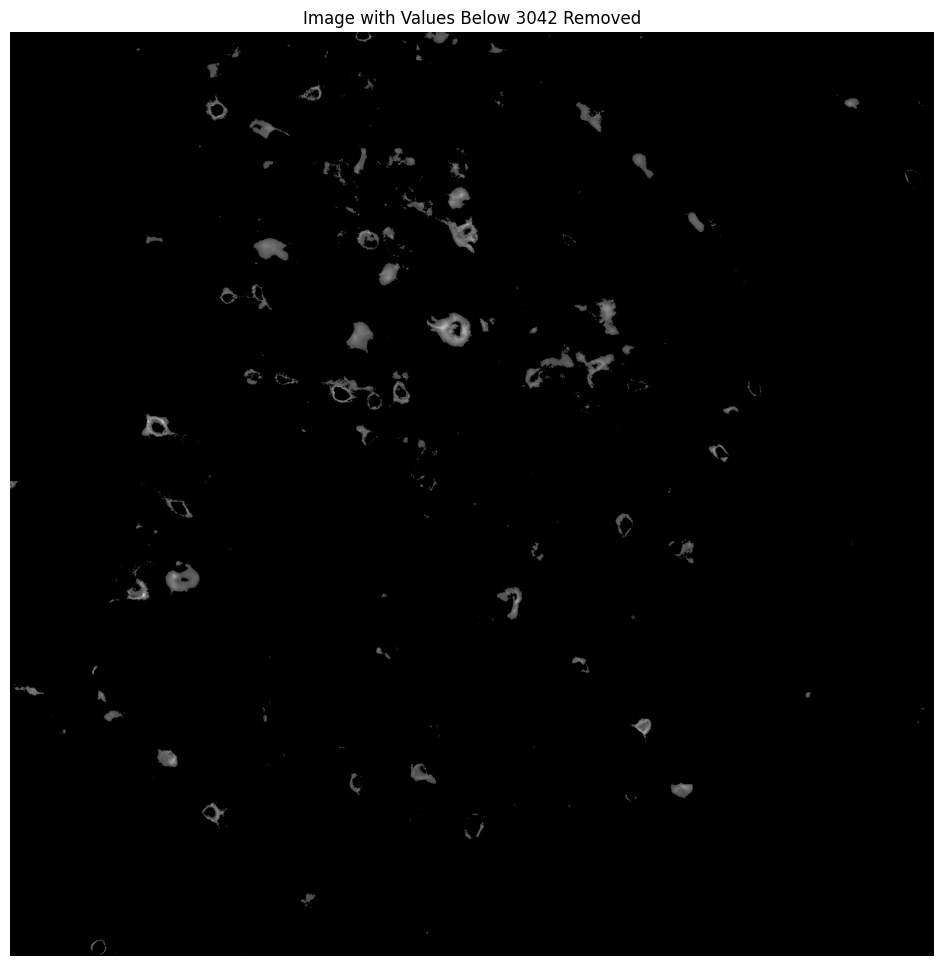

In [3]:
# Cell 3: After choosing an ideal value above, replot below without the interactive feature

# Close the interactive feature
%matplotlib inline
plt.close('all') 

# Create mask for values above the chose value (in this case 3042)
threshold = 3042
masked_img = np.where(img > threshold, img, 0)

# Create figure, should be full of only PNNs
plt.figure(figsize=(16, 12))
plt.imshow(masked_img, cmap='gray')
plt.title(f"Image with Values Below {threshold} Removed")
plt.axis('off')
plt.show()

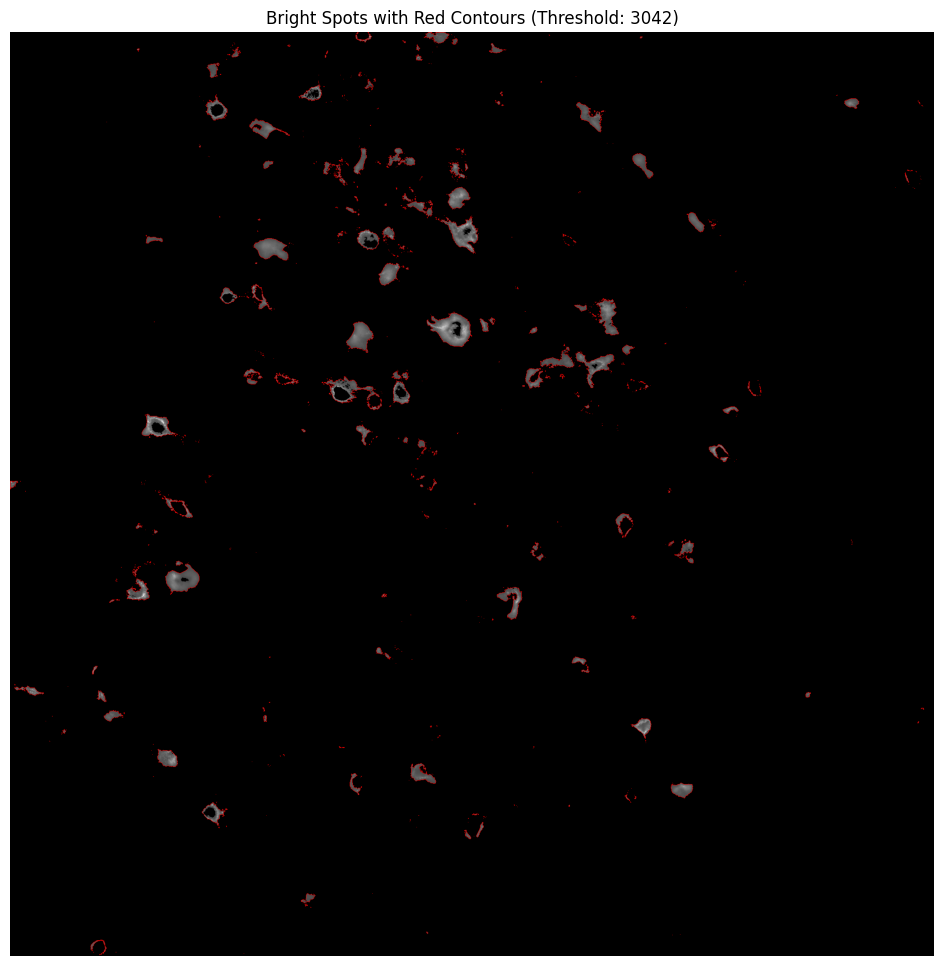

Number of contours detected: 826


In [4]:
# Cell 4: Using opencv for Contour Detection 

# Convert to uint8 for contour detection
img_8bit = (masked_img / masked_img.max() * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(img_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create RGB image for colored contours
rgb_img = np.stack([img_8bit] * 3, axis=-1)

# Draw contours in red
cv2.drawContours(rgb_img, contours, -1, (255, 0, 0), 1)  # RGB format for matplotlib

# Display the image
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title(f"Bright Spots with Red Contours (Threshold: {threshold})")
plt.axis('off')
plt.show()

# Print number of contours found
print(f"Number of contours detected: {len(contours)}")

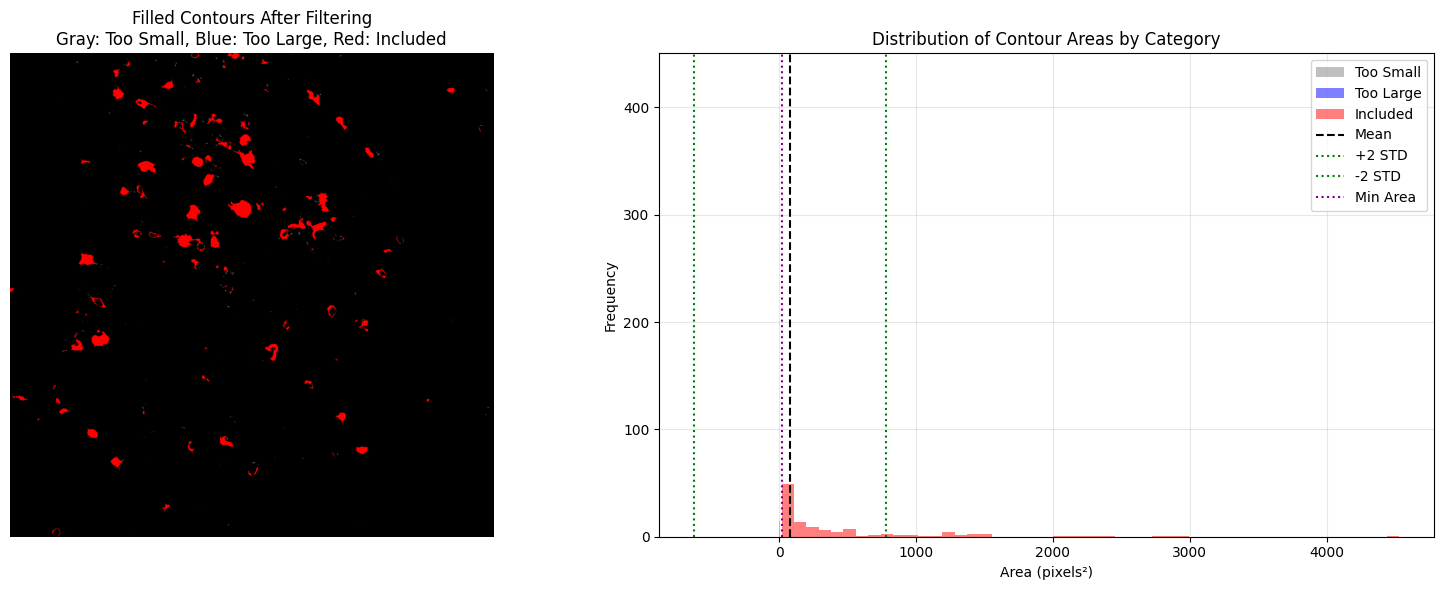

Contour counts:
Total contours: 826
Too small (< 20 pixels): 704
Too large (> 100 std from mean): 0
Included contours: 122

Area statistics for included contours:
Mean area: 534.65 pixels²
Median area: 175.25 pixels²
Min area: 20.00 pixels²
Max area: 4528.50 pixels²
Standard deviation: 763.55 pixels²


In [5]:
# Cell 5: Filter and visualize contours with filled color-coded regions

# Calculate areas of all contours
contour_areas = np.array([cv2.contourArea(contour) for contour in contours])

# Calculate statistics
area_mean = np.mean(contour_areas)
area_std = np.std(contour_areas)

# Define filters
min_area = 20  # Minimum 10 pixels
z_score_threshold = 100  # Filter anything more than X standard deviations from mean

# Create masks for different conditions
too_small_mask = (contour_areas < min_area)
z_scores = np.abs(stats.zscore(contour_areas))
too_large_mask = (z_scores >= z_score_threshold) & ~too_small_mask  # Large but not small
good_size_mask = ~too_small_mask & ~too_large_mask

# Split contours into categories
small_contours = [contour for contour, mask in zip(contours, too_small_mask) if mask]
large_contours = [contour for contour, mask in zip(contours, too_large_mask) if mask]
good_contours = [contour for contour, mask in zip(contours, good_size_mask) if mask]

# Extract intensity values for each good contour
intensity_stats = []
for contour in good_contours:
    # Create mask for this contour
    mask = np.zeros_like(img_8bit)
    cv2.drawContours(mask, [contour], 0, 255, -1)
    
    # Apply mask to get intensity values from original image
    # Convert mask to boolean for indexing
    mask_bool = mask > 0
    
    # Extract intensity values from original (unthresholded) image
    intensity_values = img[mask_bool]
    
    # Calculate intensity statistics
    if len(intensity_values) > 0:
        intensity_stats.append({
            'mean_intensity': np.mean(intensity_values),
            'median_intensity': np.median(intensity_values),
            'max_intensity': np.max(intensity_values),
            'min_intensity': np.min(intensity_values),
            'std_intensity': np.std(intensity_values)
        })
    else:
        # If contour is empty for some reason
        intensity_stats.append({
            'mean_intensity': 0,
            'median_intensity': 0,
            'max_intensity': 0,
            'min_intensity': 0,
            'std_intensity': 0
        })

# Create visualization
# Start with black background
rgb_img = np.zeros((*img_8bit.shape, 3), dtype=np.uint8)

# Fill contours with different colors (-1 for fillPoly means fill all contours)
cv2.fillPoly(rgb_img, small_contours, (128, 128, 128))  # Gray for too small
cv2.fillPoly(rgb_img, large_contours, (0, 0, 255))      # Blue for too large
cv2.fillPoly(rgb_img, good_contours, (255, 0, 0))       # Red for good size

# Display results
plt.figure(figsize=(16, 6))

# Plot 1: Filtered contours visualization
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("Filled Contours After Filtering\nGray: Too Small, Blue: Too Large, Red: Included")
plt.axis('off')

# Plot 2: Histogram comparison
plt.subplot(1, 2, 2)
plt.hist(contour_areas[too_small_mask], bins=50, alpha=0.5, label='Too Small', color='gray')
plt.hist(contour_areas[too_large_mask], bins=50, alpha=0.5, label='Too Large', color='blue')
plt.hist(contour_areas[good_size_mask], bins=50, alpha=0.5, label='Included', color='red')
plt.axvline(area_mean, color='black', linestyle='--', label='Mean')
plt.axvline(area_mean + area_std*2, color='green', linestyle=':', label='+2 STD')
plt.axvline(area_mean - area_std*2, color='green', linestyle=':', label='-2 STD')
plt.axvline(min_area, color='purple', linestyle=':', label='Min Area')
plt.xlabel("Area (pixels²)")
plt.ylabel("Frequency")
plt.title("Distribution of Contour Areas by Category")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Contour counts:")
print(f"Total contours: {len(contours)}")
print(f"Too small (< {min_area} pixels): {len(small_contours)}")
print(f"Too large (> {z_score_threshold} std from mean): {len(large_contours)}")
print(f"Included contours: {len(good_contours)}")
print("\nArea statistics for included contours:")
good_areas = contour_areas[good_size_mask]
print(f"Mean area: {np.mean(good_areas):.2f} pixels²")
print(f"Median area: {np.median(good_areas):.2f} pixels²")
print(f"Min area: {np.min(good_areas):.2f} pixels²")
print(f"Max area: {np.max(good_areas):.2f} pixels²")
print(f"Standard deviation: {np.std(good_areas):.2f} pixels²")

In [7]:
# Cell 6: Save all analysis outputs

# Create output directory based on original image name
base_name = os.path.splitext(os.path.basename(img_path))[0]
output_dir = os.path.join(os.path.dirname(img_path), base_name + '_analysis')
os.makedirs(output_dir, exist_ok=True)

# 1. Save the overlay image
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title("Original Image with Filtered PNN Regions")
plt.axis('off')
save_path = os.path.join(output_dir, 'filtered_PNNs.png')
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()

# 2. Save contour areas and statistics to CSV
pnn_data = pd.DataFrame({
    'PNN_ID': range(1, len(good_contours) + 1),
    'Area_pixels': [cv2.contourArea(contour) for contour in good_contours],
    'Mean_Intensity': [stats['mean_intensity'] for stats in intensity_stats],
    'Median_Intensity': [stats['median_intensity'] for stats in intensity_stats],
    'Max_Intensity': [stats['max_intensity'] for stats in intensity_stats],
    'Min_Intensity': [stats['min_intensity'] for stats in intensity_stats],
    'StdDev_Intensity': [stats['std_intensity'] for stats in intensity_stats]
})
stats_data = {
    'Total_PNNs': len(good_contours),
    'Mean_Area': float(np.mean(good_areas)),
    'Median_Area': float(np.median(good_areas)),
    'Min_Area': float(np.min(good_areas)),
    'Max_Area': float(np.max(good_areas)),
    'Std_Dev': float(np.std(good_areas)),
    'Mean_Intensity_Avg': float(np.mean([stats['mean_intensity'] for stats in intensity_stats])),
    'Max_Intensity_Avg': float(np.mean([stats['max_intensity'] for stats in intensity_stats])),
    'Median_Intensity_Avg': float(np.mean([stats['median_intensity'] for stats in intensity_stats]))
}

# Save individual PNN measurements
pnn_data.to_csv(os.path.join(output_dir, 'pnn_measurements.csv'), index=False)

# 3. Save analysis parameters and metadata
analysis_params = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_image': img_path,
    'parameters': {
        'threshold_value': threshold,
        'min_area': min_area,
        'z_score_threshold': z_score_threshold
    },
    'filtering_results': {
        'total_contours': len(contours),
        'excluded_small': len(small_contours),
        'excluded_large': len(large_contours),
        'included_contours': len(good_contours)
    },
    'statistics': stats_data
}

# Save parameters and metadata as JSON
with open(os.path.join(output_dir, 'analysis_metadata.json'), 'w') as f:
    json.dump(analysis_params, f, indent=4)

# Save summary statistics as CSV
pd.DataFrame([stats_data]).to_csv(os.path.join(output_dir, 'summary_statistics.csv'), index=False)

print(f"\nAnalysis results saved to: {output_dir}")
print("\nFiles saved:")
print(f"1. Overlay Image: filtered_PNNs.png")
print(f"2. Individual PNN measurements: pnn_measurements.csv")
print(f"3. Summary statistics: summary_statistics.csv")
print(f"4. Analysis metadata and parameters: analysis_metadata.json")


Analysis results saved to: /Users/ariasarch/Desktop/PNN 1000 long_analysis

Files saved:
1. Overlay Image: filtered_PNNs.png
2. Individual PNN measurements: pnn_measurements.csv
3. Summary statistics: summary_statistics.csv
4. Analysis metadata and parameters: analysis_metadata.json


In [8]:
# Cell 7: Adding Location Data and Spatial Map of PNN IDs

# 1. Calculate centroid coordinates for each PNN
print("Calculating centroid coordinates...")
centroids = []
for contour in good_contours:
    # Calculate centroid using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Avoid division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        # Fallback: use the mean of contour points
        cx, cy = np.mean(contour.reshape(-1, 2), axis=0).astype(int)
    
    centroids.append((cx, cy))

# 2. Update the PNN data with centroid coordinates
pnn_data['X_Position'] = [c[0] for c in centroids]
pnn_data['Y_Position'] = [c[1] for c in centroids]

# Save the updated dataset with location information
location_csv_path = os.path.join(output_dir, 'pnn_measurements_with_location.csv')
pnn_data.to_csv(location_csv_path, index=False)
print(f"Location data added and saved to: {location_csv_path}")

# 3. Create a spatial map visualization with PNN IDs
print("Generating spatial map of PNN IDs...")

# Create a large figure (adjust size as needed)
plt.figure(figsize=(30, 20))

# Start with the original image as background
# Convert to RGB if it's grayscale
if len(img.shape) == 2:  # If grayscale
    # Scale to 0-255 for better visibility
    img_scaled = (img / img.max() * 255).astype(np.uint8)
    # Convert to RGB
    img_rgb = cv2.cvtColor(img_scaled, cv2.COLOR_GRAY2RGB)
else:
    img_rgb = img

# Display the background image
plt.imshow(img_rgb, cmap='gray', alpha=0.7)

# Determine font size based on image dimensions
font_size = max(8, min(12, img.shape[1] // 200))

# Draw contours with semi-transparency
for i, contour in enumerate(good_contours):
    # Get the contour outline as x,y points
    contour_points = contour.reshape(-1, 2)
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'r-', linewidth=0.5, alpha=0.3)

# Add PNN IDs and centroids
for i, (cx, cy) in enumerate(centroids):
    pnn_id = i + 1  # PNN IDs start at 1
    
    # Plot centroid as a dot
    plt.plot(cx, cy, 'ro', markersize=5)
    
    # Add PNN ID as text
    plt.text(cx, cy, str(pnn_id), color='white', fontsize=font_size,
             ha='center', va='center', bbox=dict(facecolor='red', alpha=0.7, pad=1))

# Set title and remove axes
plt.title("Spatial Map of PNN IDs", fontsize=20)
plt.axis('off')

# Save the high-resolution spatial map
spatial_map_path = os.path.join(output_dir, 'pnn_spatial_map.png')
plt.savefig(spatial_map_path, bbox_inches='tight', dpi=300)
plt.close()

# 4. Create a more detailed region map for better visibility
# This creates multiple zoomed-in region maps if the image is large

# Determine if we need to create region maps (for large images)
if max(img.shape) > 2000:
    print("Creating detailed region maps for better visibility...")
    
    # Calculate how many regions to create (adjust as needed)
    grid_size = 2  # 2x2 grid, adjust for larger images
    regions = []
    
    # Calculate region dimensions
    height, width = img.shape[0], img.shape[1]
    region_height = height // grid_size
    region_width = width // grid_size
    
    # Create region maps
    for y in range(grid_size):
        for x in range(grid_size):
            # Calculate region bounds
            x_start = x * region_width
            y_start = y * region_height
            x_end = min((x + 1) * region_width, width)
            y_end = min((y + 1) * region_height, height)
            
            # Create figure for this region
            plt.figure(figsize=(15, 15))
            
            # Get the region of the image
            region_img = img_rgb[y_start:y_end, x_start:x_end]
            plt.imshow(region_img, cmap='gray', alpha=0.7)
            
            # Filter centroids that fall within this region
            region_centroids = [(i, cx, cy) for i, (cx, cy) in enumerate(centroids) 
                              if x_start <= cx < x_end and y_start <= cy < y_end]
            
            # Add PNN IDs for this region (adjust coordinates to be region-relative)
            for pnn_index, cx, cy in region_centroids:
                pnn_id = pnn_index + 1  # PNN IDs start at 1
                
                # Plot centroid as a dot (adjust coordinates to be region-relative)
                plt.plot(cx - x_start, cy - y_start, 'ro', markersize=8)
                
                # Add PNN ID as text
                plt.text(cx - x_start, cy - y_start, str(pnn_id), color='white', 
                         fontsize=10, ha='center', va='center', 
                         bbox=dict(facecolor='red', alpha=0.7, pad=2))
            
            # Set title and remove axes
            plt.title(f"Region {y*grid_size+x+1}: PNN IDs (x:{x_start}-{x_end}, y:{y_start}-{y_end})", 
                      fontsize=16)
            plt.axis('off')
            
            # Save the region map
            region_map_path = os.path.join(output_dir, f'pnn_region_{y*grid_size+x+1}_map.png')
            plt.savefig(region_map_path, bbox_inches='tight', dpi=300)
            plt.close()
    
    print(f"Created {grid_size*grid_size} detailed region maps")

print("\nSpatial analysis completed successfully!")
print(f"Spatial map saved to: {spatial_map_path}")
print("Additional outputs:")
print(f"1. PNN measurements with coordinates: {location_csv_path}")
if max(img.shape) > 2000:
    print(f"2. Detailed region maps: pnn_region_*_map.png")

Calculating centroid coordinates...
Location data added and saved to: /Users/ariasarch/Desktop/PNN 1000 long_analysis/pnn_measurements_with_location.csv
Generating spatial map of PNN IDs...
Creating detailed region maps for better visibility...
Created 4 detailed region maps

Spatial analysis completed successfully!
Spatial map saved to: /Users/ariasarch/Desktop/PNN 1000 long_analysis/pnn_spatial_map.png
Additional outputs:
1. PNN measurements with coordinates: /Users/ariasarch/Desktop/PNN 1000 long_analysis/pnn_measurements_with_location.csv
2. Detailed region maps: pnn_region_*_map.png
